# Import Relevant Libraries and Create generated_images folder

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create directory to save generated images
os.makedirs("generated_images", exist_ok=True)

# Define model hyperparameters

In [3]:
LATENT_DIM = 20  # Latent space size
INPUT_DIM = 784  # Flattened MNIST images (28x28)
BATCH_SIZE = 200
NUM_EPOCHS = 50

# Load MNIST dataset

In [4]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0  # Normalize to [0,1]
test_images = test_images.astype("float32") / 255.0

# Mask the right hald of the images

In [5]:
# Function to mask the right half of an image
def mask_right_half(images):
    images = images.copy()
    images[:, :, 14:] = 0  # Set right half (columns 14-27) to black (0)
    return images

# Mask training images before feeding them into the encoder
masked_train_images = mask_right_half(train_images).reshape(-1, INPUT_DIM)
train_images = train_images.reshape(-1, INPUT_DIM)  # Keep original images for MSE computation

# Create dataset with masked images as input and original images as target
masked_dataset = tf.data.Dataset.from_tensor_slices((masked_train_images, train_images)).shuffle(60000).batch(BATCH_SIZE)

# Encoder model

In [6]:
def build_encoder():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(360, activation="relu")(inputs)
    x = layers.Dense(180, activation="relu")(x)
    x = layers.Dense(90, activation="relu")(x)
    x = layers.Dense(45, activation="relu")(x)
    z = layers.Dense(LATENT_DIM)(x)
    return keras.Model(inputs, z, name="Encoder")

# Decoder model

In [7]:
def build_decoder():
    inputs = keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(45, activation="relu")(inputs)
    x = layers.Dense(90, activation="relu")(x)
    x = layers.Dense(180, activation="relu")(x)
    x = layers.Dense(360, activation="relu")(x)
    outputs = layers.Dense(INPUT_DIM, activation="sigmoid")(x)  # Output in range [0,1]
    return keras.Model(inputs, outputs, name="Decoder")

# Discriminator model

In [8]:
def build_discriminator():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(360, activation="relu")(inputs)
    x = layers.Dense(180, activation="relu")(x)
    x = layers.Dense(90, activation="relu")(x)
    x = layers.Dense(45, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return keras.Model(inputs, outputs, name="Discriminator")

# Optimization Algorithm and Loss Function

In [9]:
# Instantiate models
encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()

# Optimizers
ae_optimizer = keras.optimizers.Adam(learning_rate=0.001)
d_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Loss functions
reconstruction_loss_fn = keras.losses.MeanSquaredError()
adv_loss_fn = keras.losses.BinaryCrossentropy(reduction="sum")

# Model Summary
encoder.summary()
decoder.summary()
discriminator.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 360)            │       282,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 180)            │        64,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │        16,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 45)             │         4,095 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,885 (1.41 MB)

 Trainable params: 368,885 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 45)             │           945 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 90)             │         4,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 180)            │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 360)            │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 784)            │       283,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,649 (1.41 MB)

 Trainable params: 369,649 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 360)            │       282,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 180)            │        64,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 90)             │        16,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 45)             │         4,095 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,011 (1.40 MB)

 Trainable params: 368,011 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

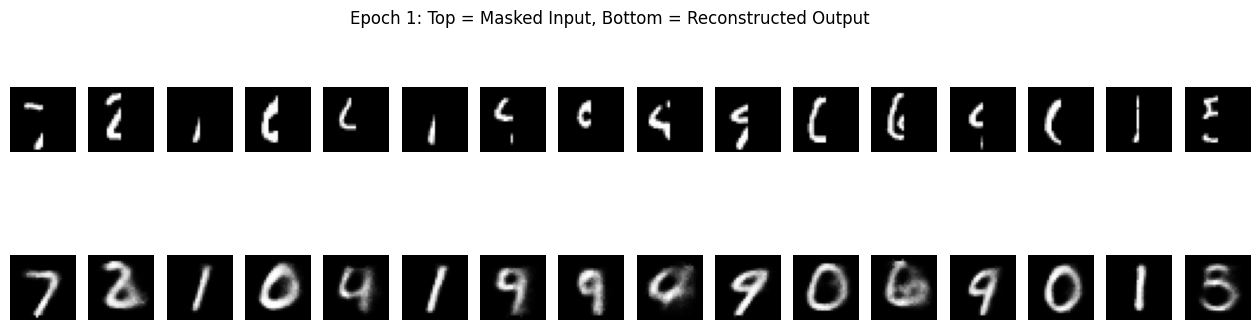

Epoch 1/50, AE Loss: 0.0273, D Loss: 10.6276
Epoch 2/50, AE Loss: 0.0263, D Loss: 1.5590
Epoch 3/50, AE Loss: 0.0243, D Loss: 13.0859
Epoch 4/50, AE Loss: 0.0239, D Loss: 7.0115
Epoch 5/50, AE Loss: 0.0227, D Loss: 0.4912


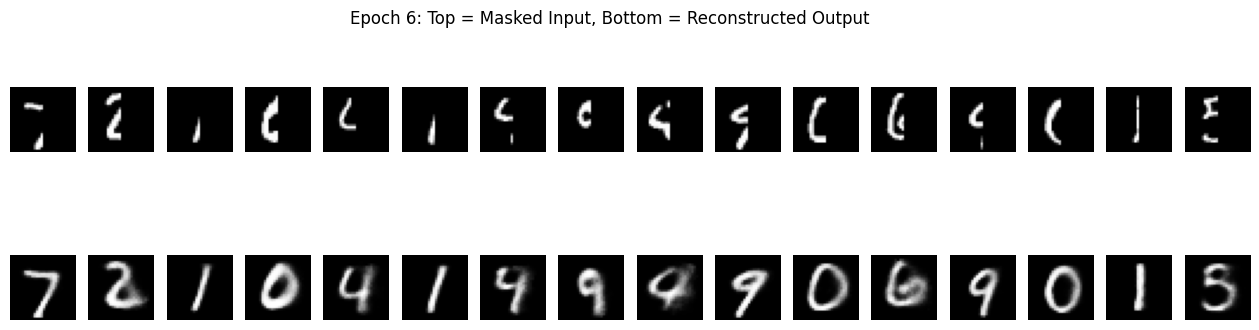

Epoch 6/50, AE Loss: 0.0227, D Loss: 5.1157
Epoch 7/50, AE Loss: 0.0197, D Loss: 4.8613
Epoch 8/50, AE Loss: 0.0207, D Loss: 4.1929
Epoch 9/50, AE Loss: 0.0218, D Loss: 0.8186
Epoch 10/50, AE Loss: 0.0219, D Loss: 0.7800


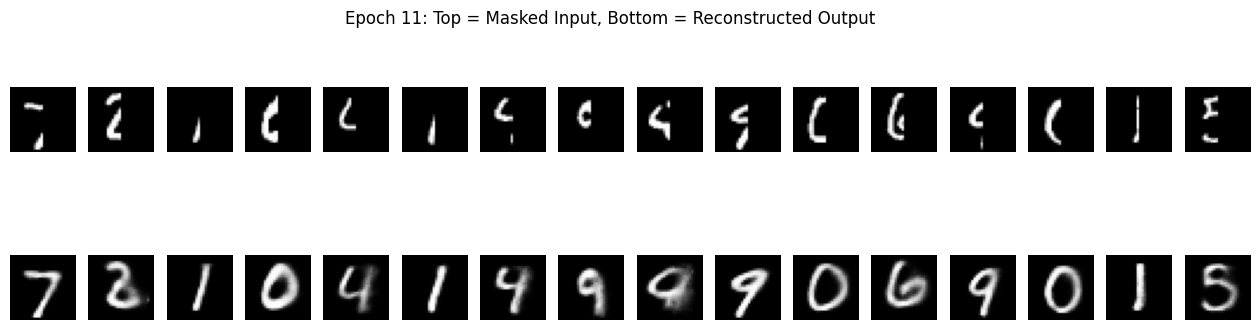

Epoch 11/50, AE Loss: 0.0207, D Loss: 0.9826
Epoch 12/50, AE Loss: 0.0202, D Loss: 3.9658
Epoch 13/50, AE Loss: 0.0195, D Loss: 0.8504
Epoch 14/50, AE Loss: 0.0201, D Loss: 4.2759
Epoch 15/50, AE Loss: 0.0194, D Loss: 0.5009


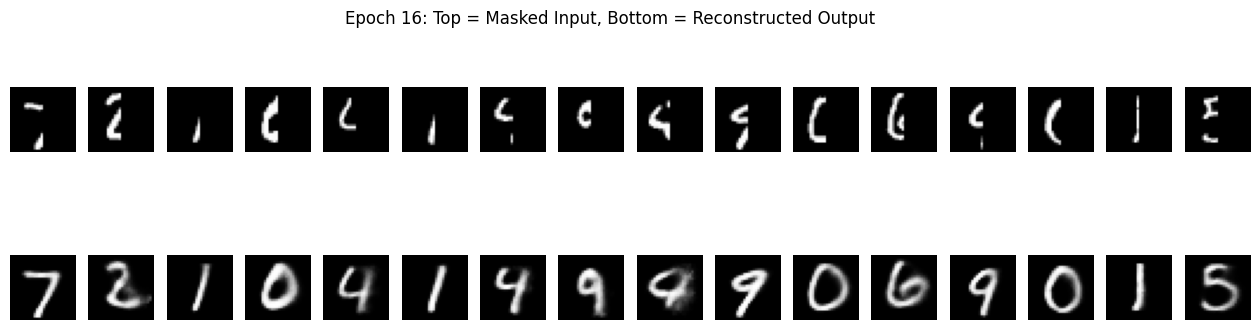

Epoch 16/50, AE Loss: 0.0184, D Loss: 0.4296
Epoch 17/50, AE Loss: 0.0197, D Loss: 14.3928
Epoch 18/50, AE Loss: 0.0204, D Loss: 5.3526
Epoch 19/50, AE Loss: 0.0189, D Loss: 1.0276
Epoch 20/50, AE Loss: 0.0181, D Loss: 4.1262


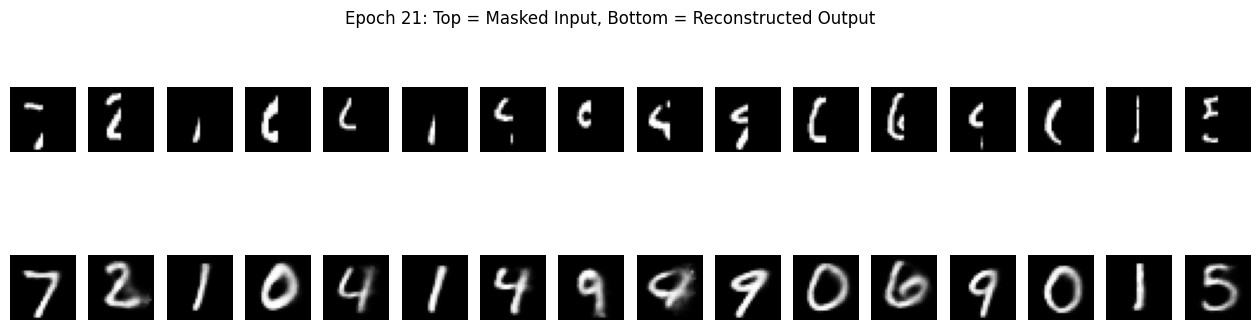

Epoch 21/50, AE Loss: 0.0184, D Loss: 5.3123
Epoch 22/50, AE Loss: 0.0181, D Loss: 1.5430
Epoch 23/50, AE Loss: 0.0180, D Loss: 3.4600
Epoch 24/50, AE Loss: 0.0190, D Loss: 6.0237
Epoch 25/50, AE Loss: 0.0188, D Loss: 4.0142


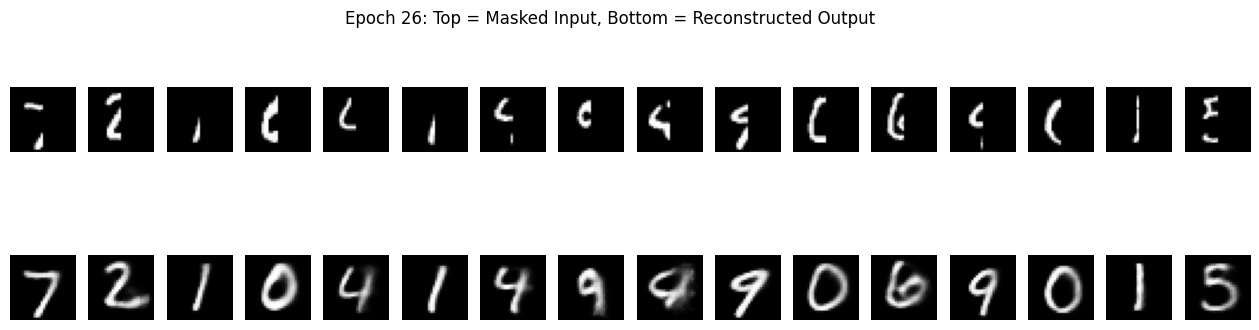

Epoch 26/50, AE Loss: 0.0178, D Loss: 0.2273
Epoch 27/50, AE Loss: 0.0170, D Loss: 0.5066
Epoch 28/50, AE Loss: 0.0182, D Loss: 4.9773
Epoch 29/50, AE Loss: 0.0175, D Loss: 1.7223
Epoch 30/50, AE Loss: 0.0168, D Loss: 3.4406


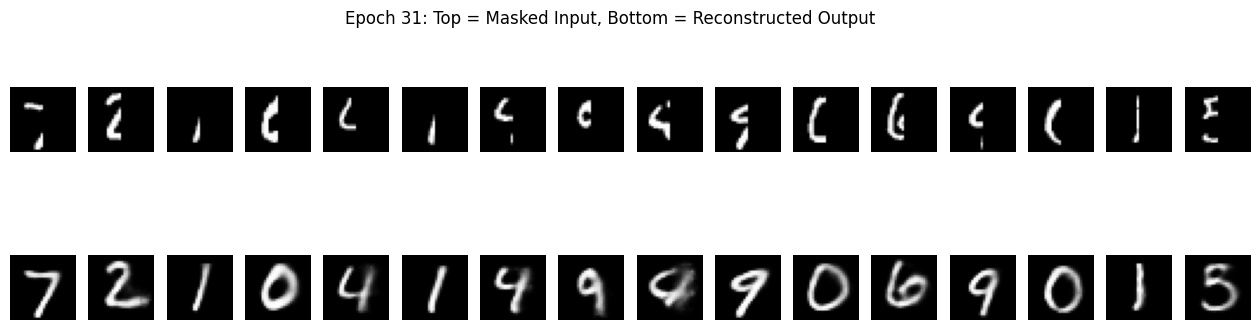

Epoch 31/50, AE Loss: 0.0171, D Loss: 3.1231
Epoch 32/50, AE Loss: 0.0183, D Loss: 0.9717
Epoch 33/50, AE Loss: 0.0168, D Loss: 1.6926
Epoch 34/50, AE Loss: 0.0170, D Loss: 4.8804
Epoch 35/50, AE Loss: 0.0160, D Loss: 1.1064


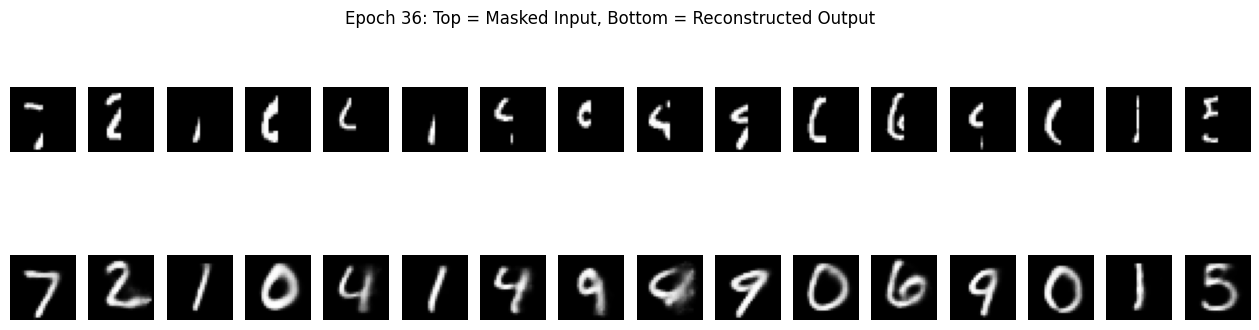

Epoch 36/50, AE Loss: 0.0169, D Loss: 4.1691
Epoch 37/50, AE Loss: 0.0167, D Loss: 0.3614
Epoch 38/50, AE Loss: 0.0174, D Loss: 2.8372
Epoch 39/50, AE Loss: 0.0171, D Loss: 0.1786
Epoch 40/50, AE Loss: 0.0184, D Loss: 1.0504


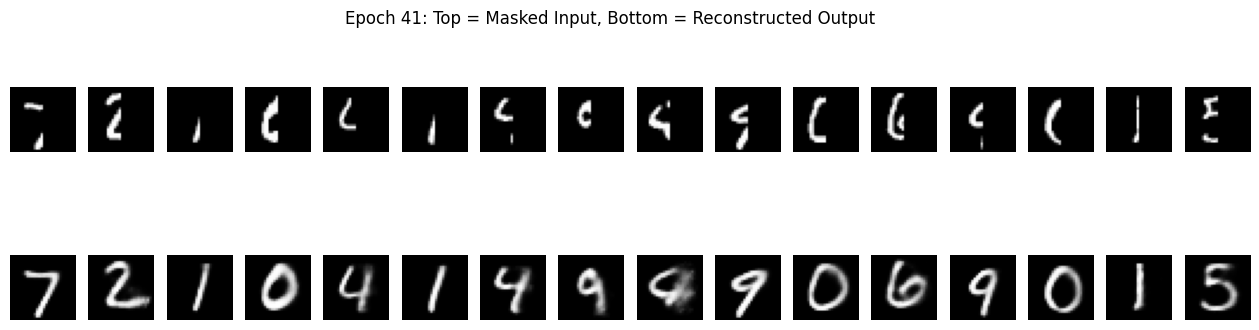

Epoch 41/50, AE Loss: 0.0158, D Loss: 0.4201
Epoch 42/50, AE Loss: 0.0156, D Loss: 4.2714
Epoch 43/50, AE Loss: 0.0166, D Loss: 3.5414
Epoch 44/50, AE Loss: 0.0159, D Loss: 0.3055
Epoch 45/50, AE Loss: 0.0160, D Loss: 3.5445


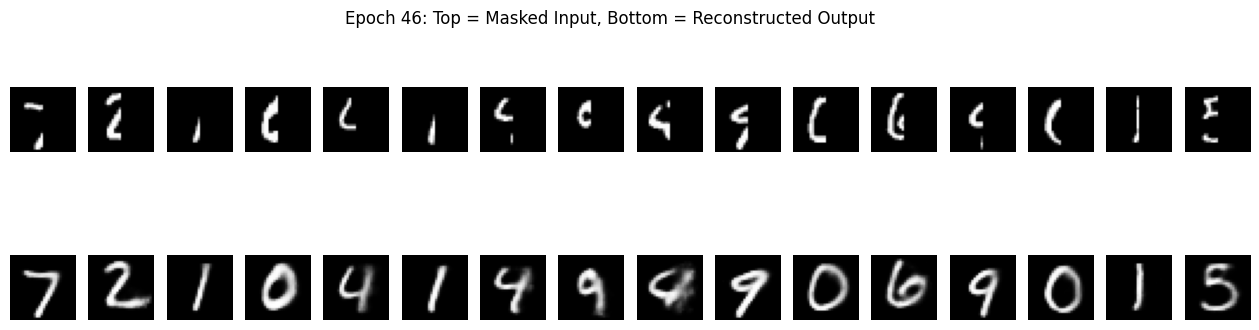

Epoch 46/50, AE Loss: 0.0166, D Loss: 0.9419
Epoch 47/50, AE Loss: 0.0162, D Loss: 0.7268
Epoch 48/50, AE Loss: 0.0156, D Loss: 1.2166
Epoch 49/50, AE Loss: 0.0159, D Loss: 0.0921
Epoch 50/50, AE Loss: 0.0159, D Loss: 4.3879


In [11]:
# Training loop
start_training_time = time.time()

for epoch in range(NUM_EPOCHS):
    for masked_batch, original_batch in masked_dataset:
        # Autoencoder step
        with tf.GradientTape() as tape:
            z = encoder(masked_batch)  # Feed masked images
            x_recon = decoder(z)  # Predict full image
            loss_ae = reconstruction_loss_fn(original_batch, x_recon)  # Compare with original
        grads = tape.gradient(loss_ae, encoder.trainable_variables + decoder.trainable_variables)
        ae_optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

        # Discriminator step
        real_labels = tf.ones((masked_batch.shape[0], 1))
        fake_labels = tf.zeros((masked_batch.shape[0], 1))
        
        with tf.GradientTape() as tape:
            d_real = discriminator(original_batch)
            d_fake = discriminator(x_recon)
            loss_d = adv_loss_fn(real_labels, d_real) + adv_loss_fn(fake_labels, d_fake)
        grads = tape.gradient(loss_d, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        # Select sample images
        sample_masked_imgs = mask_right_half(test_images[:16])  # Masked input
        sample_masked_imgs_flat = sample_masked_imgs.reshape(-1, INPUT_DIM)
    
        # Generate images from autoencoder
        sample_z = encoder(sample_masked_imgs_flat, training=False)
        generated_images = decoder(sample_z, training=False).numpy().reshape(16, 28, 28)
    
        # Plot both masked input and reconstructed output
        fig, axes = plt.subplots(2, 16, figsize=(16, 4))  # 2 rows, 16 columns
    
        for i in range(16):
            # Show masked input in first row
            axes[0, i].imshow(sample_masked_imgs[i], cmap='gray')
            axes[0, i].axis('off')
    
            # Show reconstructed output in second row
            axes[1, i].imshow(generated_images[i], cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle(f"Epoch {epoch+1}: Top = Masked Input, Bottom = Reconstructed Output")
        plt.savefig(f"generated_images/epoch_{epoch+1}.png")  # Save as PNG
        plt.show()  # Display the images
        plt.close()

        

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, AE Loss: {loss_ae:.4f}, D Loss: {loss_d:.4f}")

training_time = time.time() - start_training_time

# Evaluate the trained model

In [12]:
# Compute final evaluation metrics
sample_masked_test = mask_right_half(test_images[:1000]).reshape(-1, INPUT_DIM)
sample_z = encoder(sample_masked_test, training=False)
generated_images = decoder(sample_z, training=False).numpy().reshape(-1, INPUT_DIM)

# Compute MSE between reconstructed and original images
mse_loss = reconstruction_loss_fn(test_images[:1000].reshape(-1, INPUT_DIM), generated_images).numpy()

# Compute BCE Loss
bce_loss = adv_loss_fn(tf.ones_like(discriminator(generated_images)), discriminator(generated_images)).numpy()

# Classification Error
real_preds = discriminator(test_images[:1000].reshape(-1, INPUT_DIM), training=False)
fake_preds = discriminator(generated_images, training=False)

real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
fake_acc = tf.reduce_mean(tf.cast(fake_preds < 0.5, tf.float32))
classification_error = 1.0 - (real_acc + fake_acc) / 2

# Display the results

In [ ]:
# Print results
print(f"Training Time: {training_time:.2f} seconds")
print(f"Final MSE Loss: {mse_loss:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Classification Error: {classification_error:.4f}")

Training Time: 2935.17 seconds
Final MSE Loss: 0.0193
BCE Loss: 13593.7090
Classification Error: 0.0055
